EDA:

- distributions
- outliers
- missing values
- relationships between variables

based on insights from EDA: select relevant features and/or transformations based on domain knowledge and relationships observed during EDA. 

In [2]:
import os
import numpy as np
import pandas as pd
import sys

import seaborn as sns
import matplotlib.pyplot as plt

LOAD DATA TABLE

In [53]:
train = pd.read_csv('train_VOXELEXP.csv')
val = pd.read_csv('val_VOXELEXP.csv')

# Save area codes for later
area_codes_train = train['area_code']
area_codes_val = val['area_code']

# remove area codes and labels from data
train = train.drop(['area_code', 'label'], axis=1)
val = val.drop(['area_code', 'label'], axis=1)

In [54]:
def handle_outliers(data, exclude_columns=['species']):
    # exclude species
    features = data.select_dtypes(include=[np.number]).columns.difference(exclude_columns)
    
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping the outliers
        data[feature] = np.where(data[feature] < lower_bound, lower_bound, data[feature])
        data[feature] = np.where(data[feature] > upper_bound, upper_bound, data[feature])

In [55]:
handle_outliers(train, exclude_columns=['species'])

CONSIDER SPECIES

In [82]:
train = train[train['species'].isin([1, 2, 3])]
val = val[val['species'].isin([1, 2, 3])]

PREPARE FOR ML TRAINING

In [56]:
# Prepare the data 
X_train = train.drop('species', axis=1)
y_train = train['species']
X_val = val.drop('species', axis=1)
y_val = val['species']

SELECT FEATURES

In [57]:

def get_used_feats_names(feats_frame_columns, features_list):
    """
    not all features saved in the features.csv will be used.
    so we need to select which features are used.
    :param feats_frame_columns: all feaetures' names
                example [hrange, hmax, imax_0, imin_0, ..., imax_1,..., isk_2, ikut_2, ip90_2]
                "h" or "i": feature's name.
                    h: height, i:intensity
    :param features_list: the features' list which will be considered.
                example [h, i_max_min_sk]
                the format of "i_max_min_sk" means that only max, min, sk subfeatures for intensity will be used.
    :return:
    """
    feats_names = feats_frame_columns  # np.arr, dtype=object
    used_feats_bool = []

    for f_considered in features_list:
        if "_" in f_considered:
            f_i_subattrs = np.zeros(shape=len(feats_names)).astype("bool")
            f_name = f_considered.split("_")[0]   # feature type info. e.g. "h"(height), "i"(intensity)
            f_i_sub = f_considered.split("_")[1:] # feature sub info. e.g. "max", "min"
            f_i_sub_channels = list(filter(lambda _:_ in ["ch0", "ch1", "ch2", "ch3"], f_i_sub)) # channel info: e.g.: "ch1"
            for fi, fn in enumerate(feats_names): # fn e.g.: "imax_1", "imin_1"
                if fn[0]==f_name: # judge h or i
                    for s in f_i_sub: # s e.g. "max", "min", "ch1"
                        if str(s) in fn or s.replace("ch", "")==fn.split("_")[-1]: # e.g.: "max" in "imax_1" and ch"1"==imax_"1"
                            if len(f_i_sub_channels)==0: # no channel info. so this feature will be considered without the channel filter
                                f_i_subattrs[fi] = True
                            elif "ch"+str(fn)[-1] in f_i_sub_channels: # filter the feature info by channel.
                                f_i_subattrs[fi] = True
            used_feats_bool.append(f_i_subattrs)
        else:
            used_feats_bool.append([_[0] == f_considered for _ in feats_names])

    used_feats_bool = np.sum(used_feats_bool, axis=0, dtype=bool)  # 1-d list, all columns name which will be considered
    used_feats_names= feats_names[used_feats_bool]

    if 'D_1' in features_list and 'D_10' not in features_list:
        used_feats_names = used_feats_names[used_feats_names != 'D10']


    return used_feats_names


feats_cols = np.array(['hrange', 'hmax', 'hstd', 'hmean' ,'imax_0', 'imin_0', 'imean_0', 'isk_0', 'ikut_0', 'ip90_0',
 'imax_1', 'imin_1', 'imean_1', 'isk_1', 'ikut_1', 'ip90_1', 'imax_2', 'imin_2',
 'imean_2', 'isk_2', 'ikut_2', 'ip90_2','Rmin_0', 'Rmin_1', 'Rmin_2','Rp90_0', 'Rp90_1', 'Rp90_2', 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'penetration',
 'Rmean_0', 'Rmean_1', 'Rmean_2', 'Rmax_0', 'Rmax_1', 'Rmax_2', 'Rkut_0', 'Rkut_1', 'Rkut_2', 'Rsk_0', 'Rsk_1', 'Rsk_2', 
 '0V_min', '0V_mean', '0V_max', '0V_median', '0V_std', '0V_sk', '0V_kut', '0V_p90', 'V_points',
 '1V_min', '1V_mean', '1V_max', '1V_median', '1V_std', '1V_sk', '1V_kut', '1V_p90',
 '2V_min', '2V_mean', '2V_max', '2V_median', '2V_std', '2V_sk', '2V_kut', '2V_p90',
 '3V_min', '3V_mean', '3V_max', '3V_median', '3V_std', '3V_sk', '3V_kut', '3V_p90',
 

 'istd_0', 'irange_0', 'ip5_0', 'ip10_0', 'ip20_0', 'ip30_0', 'ip40_0', 'ipmedian_0', 'ip60_0', 'ip70_0', 'ip80_0',
 'istd_1', 'irange_1', 'ip5_1', 'ip10_1', 'ip20_1', 'ip30_1', 'ip40_1', 'ipmedian_1', 'ip60_1', 'ip70_1', 'ip80_1',
 'istd_2', 'irange_2', 'ip5_2', 'ip10_2', 'ip20_2', 'ip30_2', 'ip40_2', 'ipmedian_2', 'ip60_2', 'ip70_2', 'ip80_2',
 'Rstd_0', 'Rrange_0', 'Rp5_0', 'Rp10_0', 'Rp20_0', 'Rp30_0', 'Rp40_0', 'Rpmedian_0', 'Rp60_0', 'Rp70_0', 'Rp80_0',
 'Rstd_1', 'Rrange_1', 'Rp5_1', 'Rp10_1', 'Rp20_1', 'Rp30_1', 'Rp40_1', 'Rpmedian_1', 'Rp60_1', 'Rp70_1', 'Rp80_1',
 'Rstd_2', 'Rrange_2', 'Rp5_2', 'Rp10_2', 'Rp20_2', 'Rp30_2', 'Rp40_2', 'Rpmedian_2', 'Rp60_2', 'Rp70_2', 'Rp80_2',
 'Nstd', 'Nrange', 'Np5', 'Np10', 'Np20', 'Np30', 'Np40', 'Npmedian', 'Np60', 'Np70', 'Np80',
 'Nmax', 'Nmin', 'Nmean', 'Nsk', 'Nkut', 'Np90',
 'Amax', 'Amin', 'Amean', 'Ask', 'Akut', 'Ap90', 'Astd', 'Arange', 'Ap5','Ap10','Ap20','Ap30','Ap40','Apmedian','Ap60','Ap70','Ap80',
 'Xmax', 'Xmin', 'Xmean', 'Xsk', 'Xkut', 'Xp90', 'Xstd', 'Xrange', 'Xp5','Xp10','Xp20','Xp30','Xp40','Xpmedian','Xp60','Xp70','Xp80',
 'CA', 'CV', 'CD', 'HP10', 'HP20','HP30','HP40','HP50','HP60','HP70','HP80','HP90',
 'ibinm1_0','ibinm1_1','ibinm1_2',
 'ibinm2_0','ibinm2_1','ibinm2_2',
 'ibinm3_0','ibinm3_1','ibinm3_2',
 'ibinx1_0','ibinx1_1','ibinx1_2',
 'ibinx2_0','ibinx2_1','ibinx2_2',
 'ibinx3_0','ibinx3_1','ibinx3_2',

 'Rbinm1_0','Rbinm1_1','Rbinm1_2',
 'Rbinm2_0','Rbinm2_1','Rbinm2_2',
 'Rbinm3_0','Rbinm3_1','Rbinm3_2',
 'Rbinx1_0','Rbinx1_1','Rbinx1_2',
 'Rbinx2_0','Rbinx2_1','Rbinx2_2',
 'Rbinx3_0','Rbinx3_1','Rbinx3_2',
 'Nbinm1', 'Nbinm2', 'Nbinm3', 'Nbinx1', 'Nbinx2', 'Nbinx3',
 'Abinm1', 'Abinm2', 'Abinm3',
 'Abinx1', 'Abinx2', 'Abinx3',
 'Xbinm1', 'Xbinm2', 'Xbinm3',
 'Xbinx1', 'Xbinx2', 'Xbinx3'
 ])

In [7]:
feats_to_use = ['2']
feats_to_use = get_used_feats_names(feats_frame_columns=feats_cols, features_list=feats_to_use)
print('FEATURES USED: \n', feats_to_use)

X_train = X_train[feats_to_use]
X_val = X_val[feats_to_use]

feats_to_use = np.append(feats_to_use, 'species')
train_subset = train[feats_to_use]
val_subset = val[feats_to_use]

FEATURES USED: 
 ['0V_min' '0V_mean' '0V_max' '0V_median' '0V_std' '0V_sk' '0V_kut'
 '0V_p90' 'V_points']


KeyError: "['V_points'] not in index"

HISTOGRAM

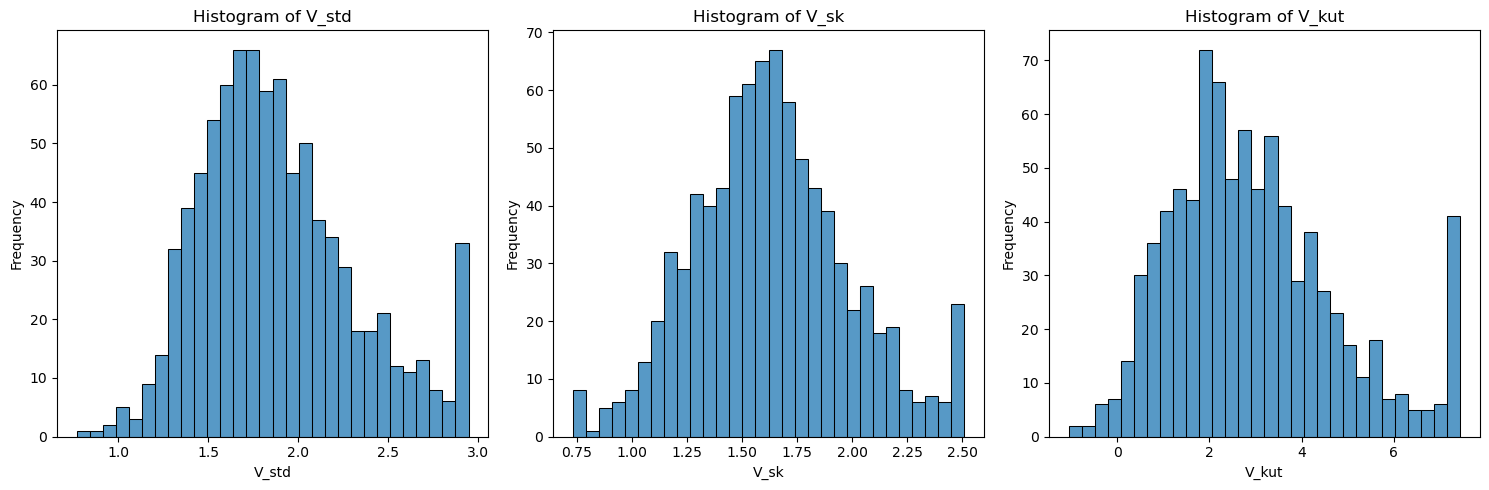

In [39]:

features = get_used_feats_names(feats_frame_columns=feats_cols, features_list=['1_kut', '1_sk', '1_std'])

# setting up the subplot grid
n_features = len(features)
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(5*n_features, 5))

for i, feature in enumerate(features):
    sns.histplot(train[feature], bins=30, kde=False, ax=axes[i])

    if feature=='V_points':
        feature = 'Points'
    else:
        feature = feature[1:]

    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

BOXPLOTS

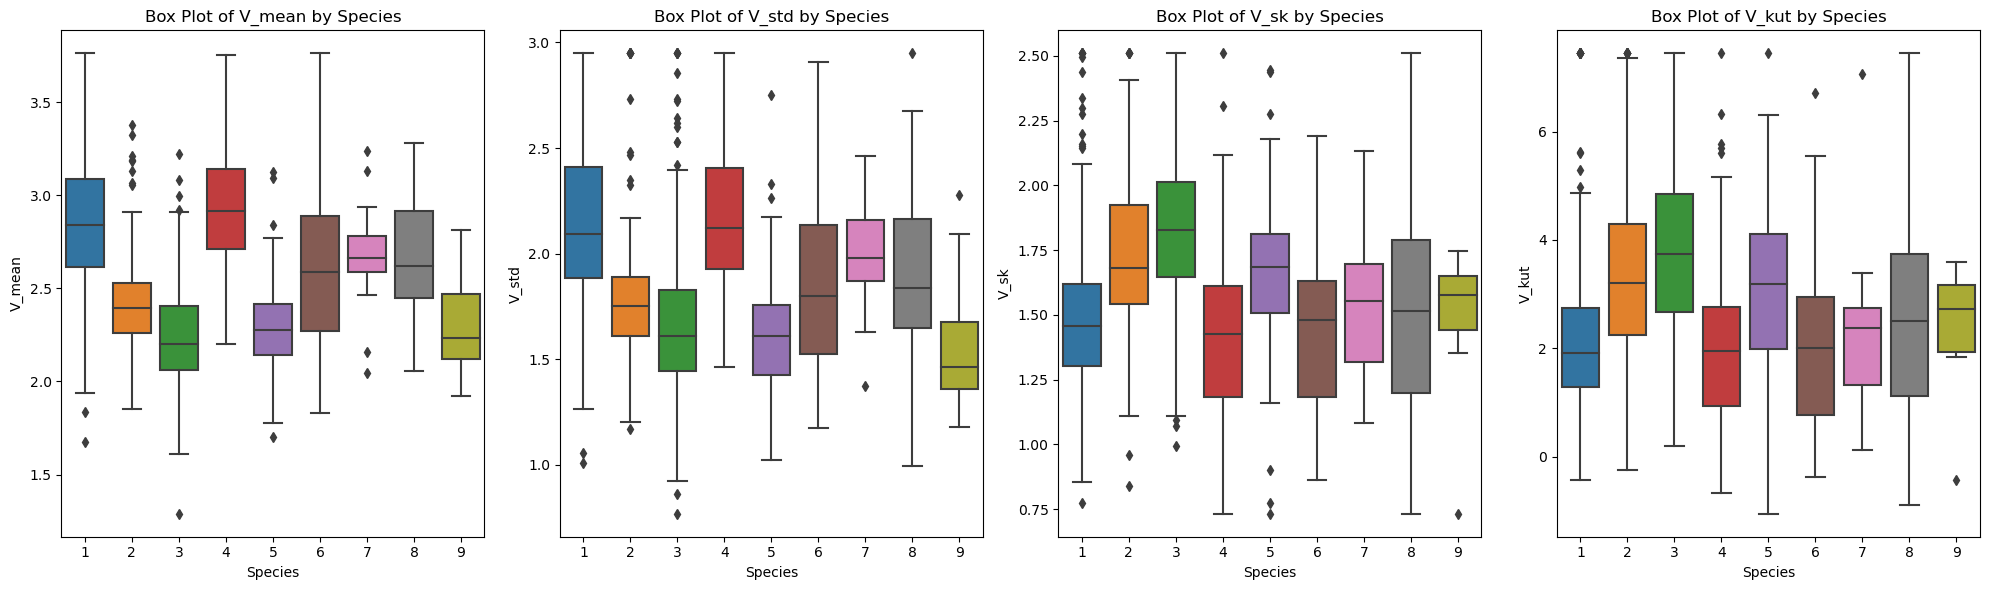

In [59]:
features = get_used_feats_names(feats_frame_columns=feats_cols, features_list=['1_mean', '1_kut', '1_sk', '1_std',])


n_features = len(features)
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(5*n_features, 6)) 

for i, feature in enumerate(features):
    # box plot for each feature by species
    sns.boxplot(x='species', y=feature, data=train, ax=axes[i], showfliers=True)
   
    if feature == 'V_points':
        feature = 'Points'
    else:
        feature = feature[1:]
    axes[i].set_title(f'Box Plot of {feature} by Species')
    axes[i].set_xlabel('Species')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

CORRELATION

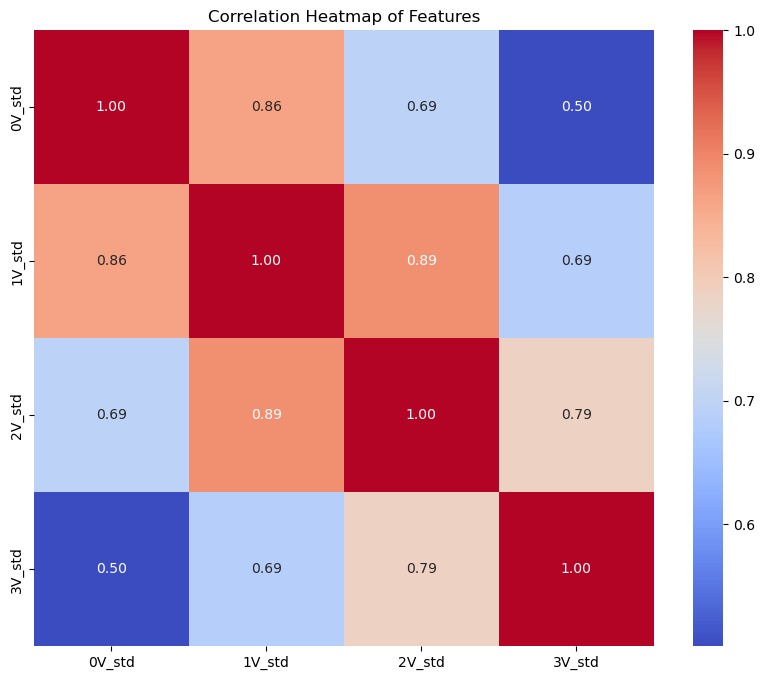

In [99]:
sorted_cols = sorted(train_subset.columns[:-1])
corr = train_subset[sorted_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()


Resultater correlation heatmap:

Practical tips:
- corr threshold 0.8/0.9 could mean grounds for consolidation or removal

intensity:
- imean = ip90
- ikut_1, ikut_2 = imax_1, imax_2. ikut_0 er mindre lik imax_0
- isk er ganske lik ikut  --> isk er ganske lik imax

ratios:
- Rmean = Rmax = Rp90
- omvendt korrelasjon innad i rsk og rkut

D:
- 3/4 i avstand for å få minst mulig korrelasjon

V:
- samme korrelasjon som intensity faktisk
- ingen stor korrelasjon mellom antall punkt og features
- V_std er lik V_p90 er lik V_mean

h og pen:
- hrange = hmax
- penetration ikke korrelert

h, pen, D og V_points:
- litt korrelasjon mellom h og antall punkt
- lite korrelasjon generelt

intensity + h, pen og V_points:
- ingen korrelasjon

intensity og V:
